# Example LFPy: Compare forwardmodels
Example file combining set up of neuron model and simulation of membrane
currents in LFPy, using the different `lfpykit` classes
`CellGeometry`, `RecExtElectrode`, `PointSourcePotential`,
`LineSourcePotential`, `CurrentDipoleMoment` and
`InfiniteVolumeConductor` to predict extracellular potentials.

Extracellular potentials are computed both in vicinity and remotely
from the neuron geometry. The latter also demonstrates use of the
dipole approximation to extracellular potentials.


In [1]:
%matplotlib inline

In [2]:
## if running on mybinder or similar, uncomment and run the two following lines to install LFPy. 
## Then restart the kernel.
#!conda install mpi4py -y
#!pip install -e git+https://github.com/LFPy/LFPy.git@master#egg=LFPy

In [3]:
# compile sinsyn.mod file using nrnivmodl script
!nrnivmodl

/usr/bin/xcrun
/Users/ehagen/Repositories/LFPykit/examples
sinsyn.mod
sinsyn.mod
 -> Compiling mod_func.c
x86_64-apple-darwin13.4.0-clang -O2   -I. -I..   -I/Users/ehagen/anaconda3/envs/lfpy/lib/python3.8/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.0.4_1/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL sinsyn.mod
MODLUNIT=/Users/ehagen/anaconda3/envs/lfpy/lib/python3.8/site-packages/neuron/.data/share/nrn/lib/nrnunits.lib \
	  /Users/ehagen/anaconda3/envs/lfpy/lib/python3.8/site-packages/neuron/.data/bin/nocmodl sinsyn.mod
Translating sinsyn.mod into sinsyn.c
Thread Safe
 -> Compiling x86_64/sinsyn.c
(cd .. ; x86_64-apple-darwin13.4.0-clang -O2   -I. -I..   -I/Users/ehagen/anaconda3/envs/lfpy/lib/python3.8/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.0.4_1/include -fPIC -c x86_64/sinsyn.c -o x86_64/sinsyn.o)
 => LINKING library x86_64/libnrnmech.dylib Mod files: sinsyn.mod
(cd .. ; x86_64-apple-darwin13.4.0-clang++ -O2 -DVERSION_INFO='7.8

In [4]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.gridspec import GridSpec
import LFPy
from lfpykit import CellGeometry, RecExtElectrode, \
    PointSourcePotential, LineSourcePotential, CurrentDipoleMoment
from lfpykit.eegmegcalc import InfiniteVolumeConductor

In [5]:
# LFPy.Cell parameters
cellParameters = {
    'morphology': 'L5_Mainen96_LFPy.hoc',  # morphology file
    'v_init': -65,                         # initial voltage
    'cm': 1.0,                             # membrane capacitance
    'Ra': 150,                             # axial resistivity
    'passive': True,                       # insert passive channels
    'passive_parameters': {"g_pas": 1. / 3E4,
                           "e_pas": -65},  # passive params
    'dt': 2**-4,                           # simulation time res
    'tstart': 0.,                          # start t of simulation
    'tstop': 50.,                          # end t of simulation
}

# create LFPy.Cell instance
cell = LFPy.Cell(**cellParameters)
cell.set_rotation(x=4.98919, y=-4.33261, z=0.)

# parameters for exponential synapse
synapseParameters = {
    'idx': cell.get_closest_idx(x=0, y=0, z=800),  # compartment
    'e': 0,                                # reversal potential (mV)
    'syntype': 'ExpSyn',                   # synapse type
    'tau': 2,                              # synaptic time constant (ms)
    'weight': 0.01,                        # synaptic weight (µS)
    'record_current': True                 # record synapse current
}

# create synapse and set activation times
synapse = LFPy.Synapse(cell, **synapseParameters)
synapse.set_spike_times(np.array([10., 15., 20., 25.]))  # ms

# run simulation, record membrane currents
cell.simulate(rec_imem=True)

## proximal extracellular potentials

In [6]:
# shared parameters for forward models
ForwardModelParameters = {         # parameters for ForwardModel class
    'sigma': 0.3,              # Extracellular potential
    'x': np.zeros(31) + 25,      # Coordinates of electrode contacts
    'y': np.zeros(31),
    'z': np.linspace(-500, 1000, 31),
}

# list of models and labels
models = [PointSourcePotential, LineSourcePotential, RecExtElectrode]
labels = ['pointsource', 'linesource', 'root_as_point']

In [7]:
def colorbar(fig, ax, im,
             width=0.1,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw colorbar without resizing the axes object to make room
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

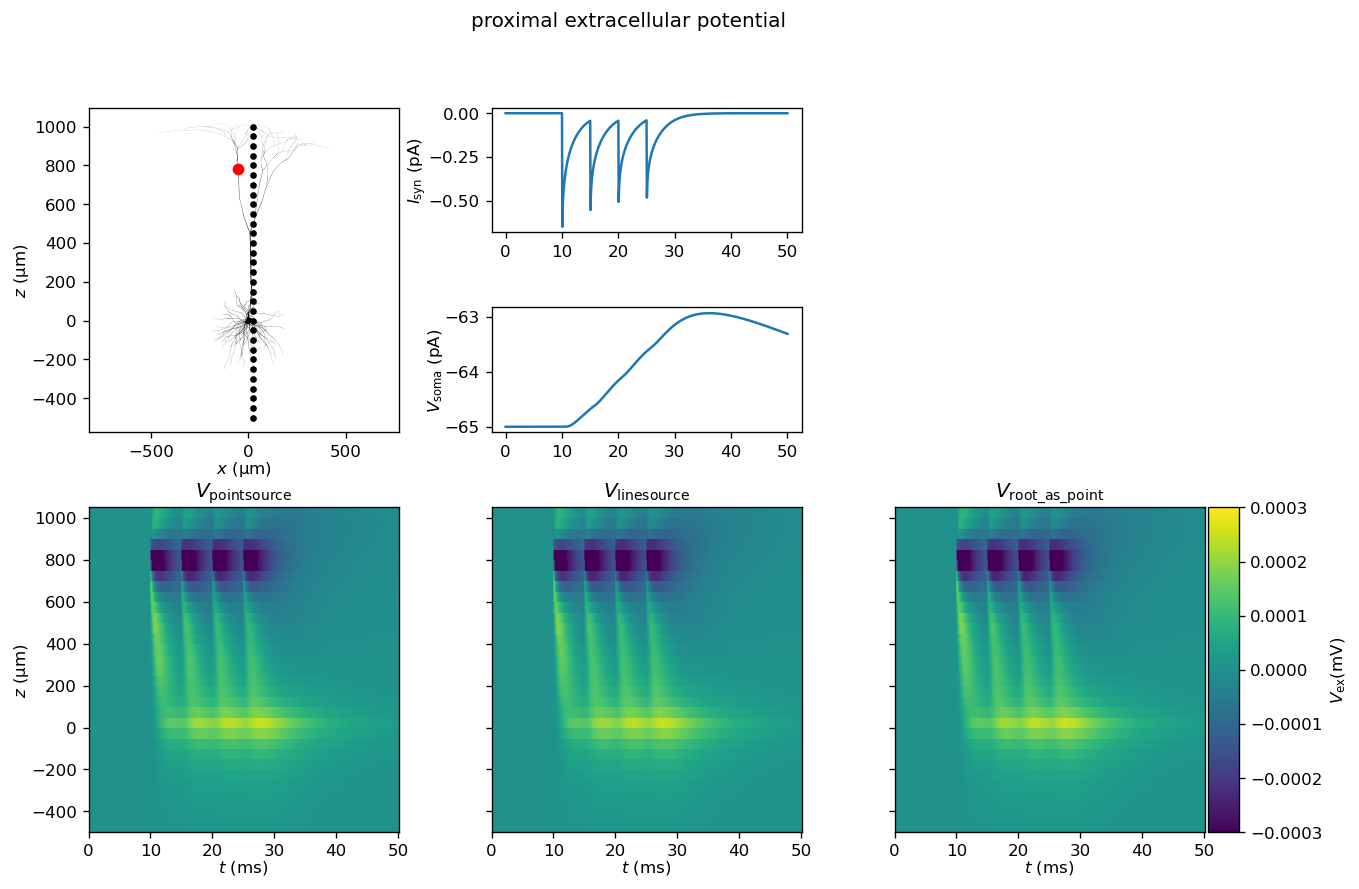

In [8]:
# create figure
fig = plt.figure(figsize=(12, 8), dpi=120)
fig.suptitle('proximal extracellular potential')
fig.subplots_adjust(hspace=0.6, wspace=0.3)
gs = GridSpec(4, len(models))

# draw morphology, synapse location and measurement sites
zips = []
for x, z in cell.get_idx_polygons(projection=('x', 'z')):
    zips.append(list(zip(x, z)))
polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors='k')
ax = fig.add_subplot(gs[:2, 0])
ax.add_collection(polycol)
ax.plot(cell.x[synapse.idx].mean(),
        cell.z[synapse.idx].mean(), 'ro')
ax.plot(ForwardModelParameters['x'], ForwardModelParameters['z'], 'k.')
ax.axis(ax.axis('equal'))
ax.set_ylabel('$z$ (µm)', labelpad=0)
ax.set_xlabel('$x$ (µm)', labelpad=0)

# plot synapse current
ax = fig.add_subplot(gs[0, 1])
ax.plot(cell.tvec, synapse.i)
ax.set_ylabel(r'$I_\mathrm{syn}$ (pA)', labelpad=0)

# plot somatic voltage
ax = fig.add_subplot(gs[1, 1], sharex=ax)
ax.plot(cell.tvec, cell.somav)
ax.set_ylabel(r'$V_\mathrm{soma}$ (pA)', labelpad=0)

# compute extracellular potential for each forward model
for i, (label, Model) in enumerate(zip(labels, models)):
    if Model is RecExtElectrode:
        model = Model(cell, method=label, **ForwardModelParameters)
    else:
        model = Model(cell, **ForwardModelParameters)
    M = model.get_transformation_matrix()
    V = M @ cell.imem

    # draw extracellular potential
    ax = fig.add_subplot(gs[2:, i])
    im = ax.pcolormesh(np.r_[cell.tvec, cell.tvec[-1] + cell.dt],
                       np.r_[model.z, model.z[-1] + np.diff(model.z)[-1]],
                       V, vmin=-0.0003, vmax=.0003)
    ax.axis(ax.axis('tight'))
    ax.set_title(r'$V_\mathrm{' + label.replace('_', '\_') + '}$')
    if i == 0:
        ax.set_ylabel('$z$ (µm)', labelpad=0)
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('$t$ (ms)', labelpad=0)

cb = colorbar(fig, ax, im)
cb.set_label(r'$V_\mathrm{ex}$(mV)')

## distal extracellular potentials
Compare predictions remotely from the cell using also the current dipole
moment approximation in infinite homogeneous conductive medium.

In [9]:
# shared parameters for forward models
DistalParameters = {         # parameters for ForwardModel class
    'sigma': 0.3,              # Extracellular potential
    'x': np.zeros(31) + 1000,      # Coordinates of electrode contacts
    'y': np.zeros(31),
    'z': np.linspace(-500, 1000, 31),
}

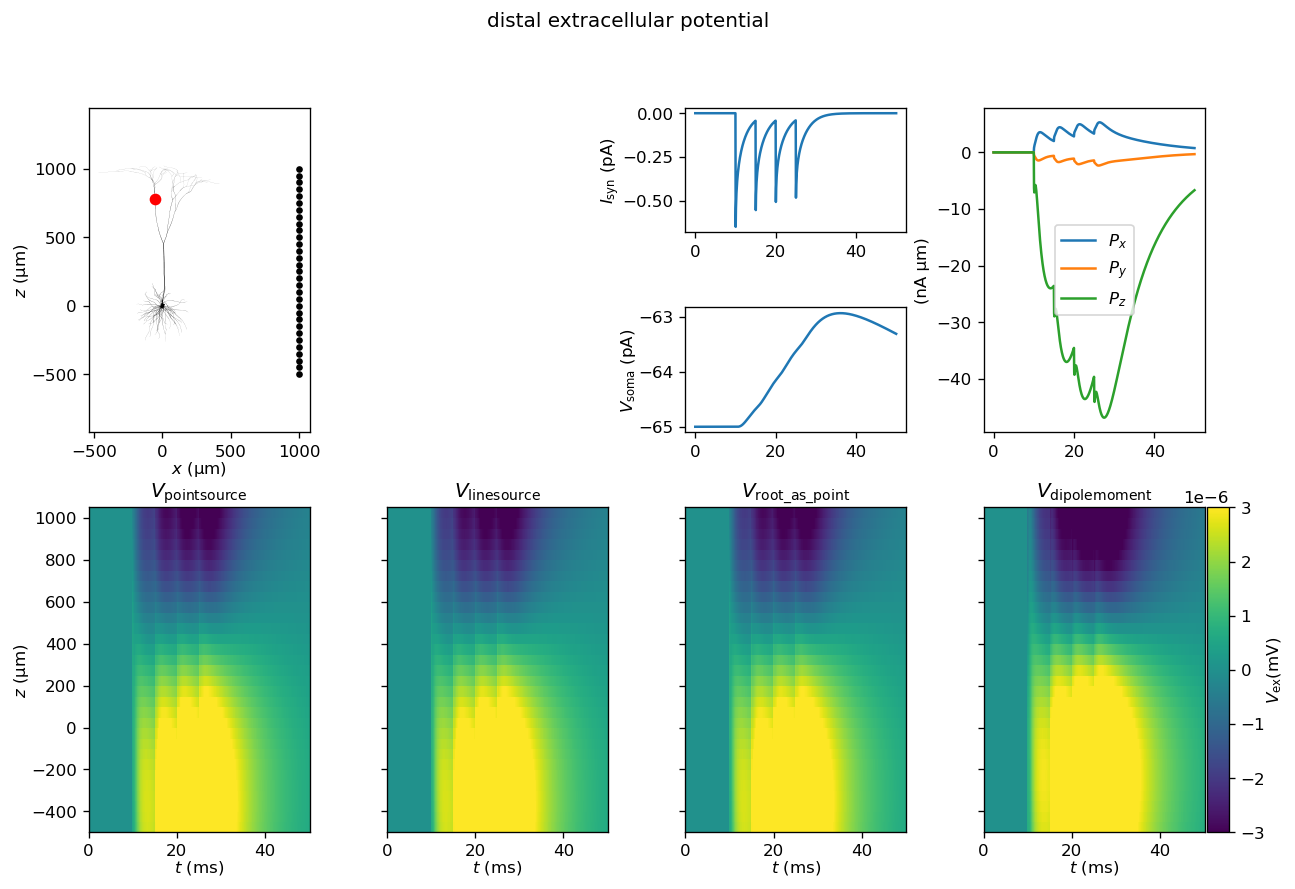

In [10]:
# create figure object
fig = plt.figure(figsize=(12, 8), dpi=120)
fig.suptitle('distal extracellular potential')
fig.subplots_adjust(hspace=0.6, wspace=0.35)
gs = GridSpec(4, len(models) + 1)

# draw morphology, synapse location, measurement sites
zips = []
for x, z in cell.get_idx_polygons(projection=('x', 'z')):
    zips.append(list(zip(x, z)))
polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors='k')

ax = fig.add_subplot(gs[:2, 0])
ax.plot(DistalParameters['x'], DistalParameters['z'], 'k.', clip_on=False)
ax.add_collection(polycol)
ax.plot(cell.x[synapse.idx].mean(),
        cell.z[synapse.idx].mean(), 'ro')
ax.set_xlim(cell.x.min(), 1000)
ax.set_ylabel('$z$ (µm)', labelpad=0)
ax.set_xlabel('$x$ (µm)', labelpad=0)
ax.axis(ax.axis('equal'))

# plot synapse current
ax = fig.add_subplot(gs[0, 2])
ax.plot(cell.tvec, synapse.i)
ax.set_ylabel(r'$I_\mathrm{syn}$ (pA)', labelpad=0)

# plot somatic voltage
ax = fig.add_subplot(gs[1, 2], sharex=ax)
ax.plot(cell.tvec, cell.somav)
ax.set_ylabel(r'$V_\mathrm{soma}$ (pA)', labelpad=0)

# compute potential using different volume conductor models
for i, (label, Model) in enumerate(zip(labels, models)):
    if Model is RecExtElectrode:
        model = Model(cell, method=label, **DistalParameters)
    else:
        model = Model(cell, **DistalParameters)

    # get linear response matrix
    M = model.get_transformation_matrix()

    # compute extracellular potentials
    V = M @ cell.imem

    # image plot of extracellular potential
    ax = fig.add_subplot(gs[2:, i])
    im = ax.pcolormesh(np.r_[cell.tvec, cell.tvec[-1] + cell.dt],
                       np.r_[model.z, model.z[-1] + np.diff(model.z)[-1]],
                       V, vmin=-3e-6, vmax=3e-6)
    ax.axis(ax.axis('tight'))
    ax.set_title(r'$V_\mathrm{' + label.replace('_', '\_') + '}$')
    if i == 0:
        ax.set_ylabel('$z$ (µm)', labelpad=0)
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('$t$ (ms)', labelpad=0)

# compute current dipole moment of transmembrane currents
cdm = CurrentDipoleMoment(cell=cell)
P = cdm.get_transformation_matrix() @ cell.imem

# plot components of current dipole moment
ax = fig.add_subplot(gs[:2, -1])
ax.plot(cell.tvec, P.T)
ax.legend(['$P_x$', '$P_y$', '$P_z$'], loc='best')
ax.set_ylabel('(nA µm)')

# relative location of dipole vs. root segment
R = np.c_[DistalParameters['x'] - cell.x.mean(),
          DistalParameters['y'] - cell.y.mean(),
          DistalParameters['z'] - cell.z.mean()]

# compute mapping between dipole moment and extracellular potential
ivc = InfiniteVolumeConductor(sigma=0.3)
M = ivc.get_transformation_matrix(R)

# compute dipole potential
V = M @ P

# plot dipole potential
ax = fig.add_subplot(gs[2:, -1])
im = ax.pcolormesh(np.r_[cell.tvec, cell.tvec[-1] + cell.dt],
                   np.r_[model.z, model.z[-1] + np.diff(model.z)[-1]],
                   V, vmin=-3e-6, vmax=3e-6)
ax.set_title(r'$V_\mathrm{' + 'dipole moment' + '}$')
ax.set_yticklabels([])
ax.set_xlabel('$t$ (ms)', labelpad=0)
cb = colorbar(fig, ax, im)
cb.set_label(r'$V_\mathrm{ex}$(mV)', labelpad=0)